In [1]:
#pick one that is about Neptune size and short period
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
import batman

In [2]:
search_result = lk.search_targetpixelfile('TIC 158297421', mission='TESS', sector=13)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [3]:
search_result #looks like a pandas output

#,observation,target_name,productFilename,distance
0,TESS Sector 13,158297421,tess2019169103026-s0013-0000000158297421-0146-s_tp.fits,0.0


In [4]:
tpf = search_result.download(quality_bitmask='default')

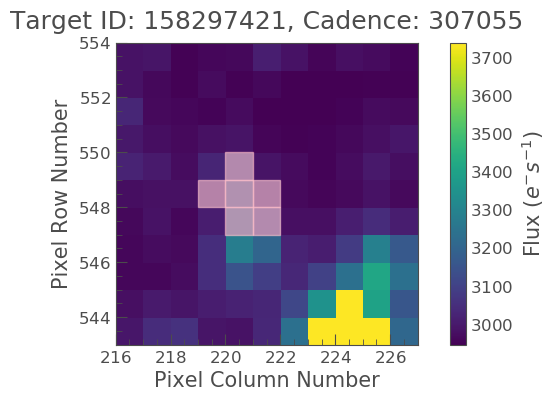

In [77]:
#viewing the aperture
tpf.plot(aperture_mask=tpf.pipeline_mask);

In [78]:
#creating the lightcurve
lc = tpf.to_lightcurve()

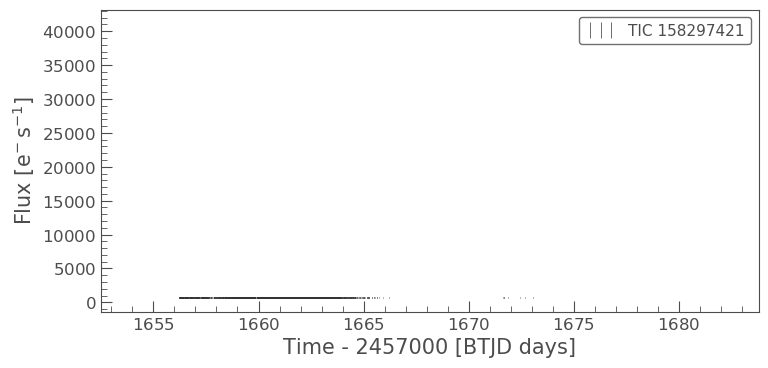

In [79]:
lc.errorbar();

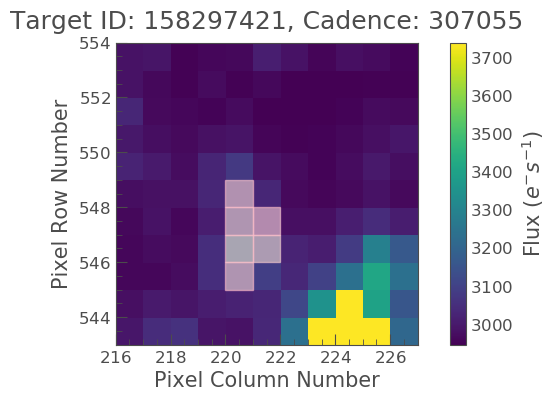

In [153]:
#adjusting the aperture
aperture_mask = tpf.create_threshold_mask(threshold=2) #threshold determines what flux a pixel must have to be included
#in the aperture. higher threshold, fewer pixels
tpf.plot(aperture_mask=aperture_mask)

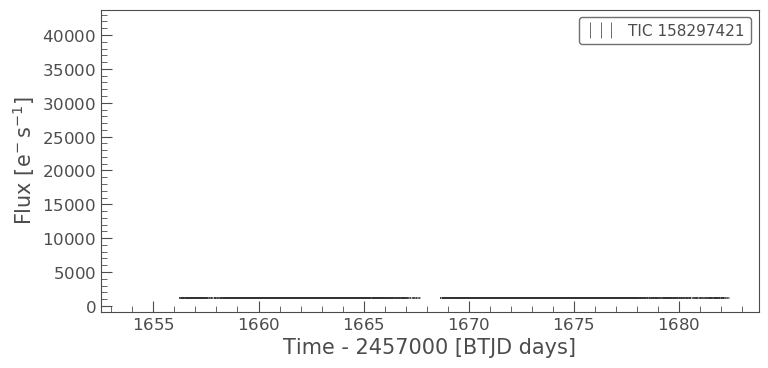

In [154]:
#creating lightcurve from adjusted aperture
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.errorbar();
#plt.ylim(1200,1300)

(0.95, 1.05)

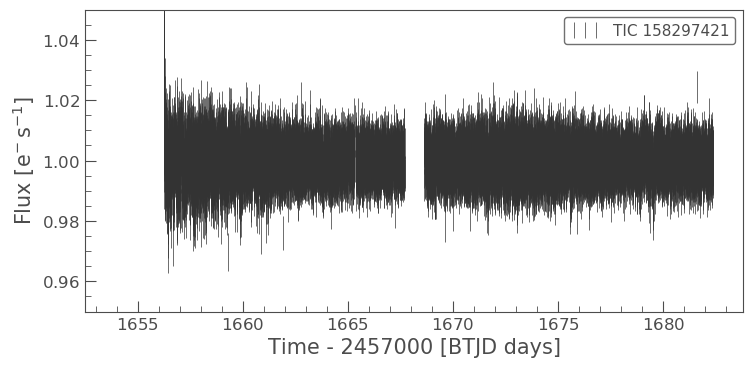

In [155]:
#cleaning up the light curve
flat_lc = lc.flatten(window_length=1001) #lower window_length smooths more
flat_lc.errorbar();
plt.ylim(.95,1.05)
#plt.ylim(1656,1682)

In [156]:
mask = (flat_lc.time < 1652) | (flat_lc.time > 1657) #keeps all data in specified times

(1656, 1682)

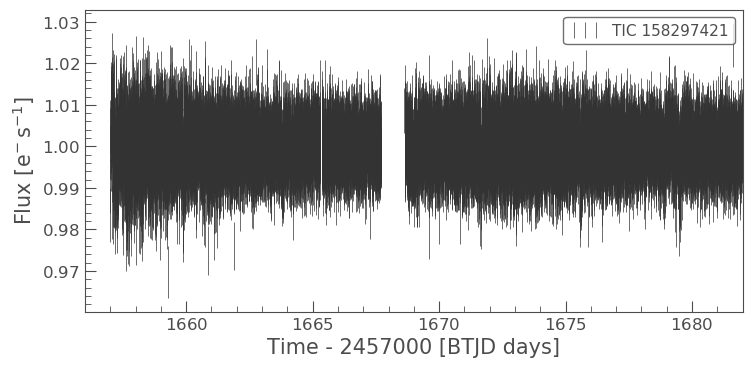

In [157]:
masked_lc = flat_lc[mask]
masked_lc.errorbar();
#plt.ylim(.95,1.05)
plt.xlim(1656,1682)

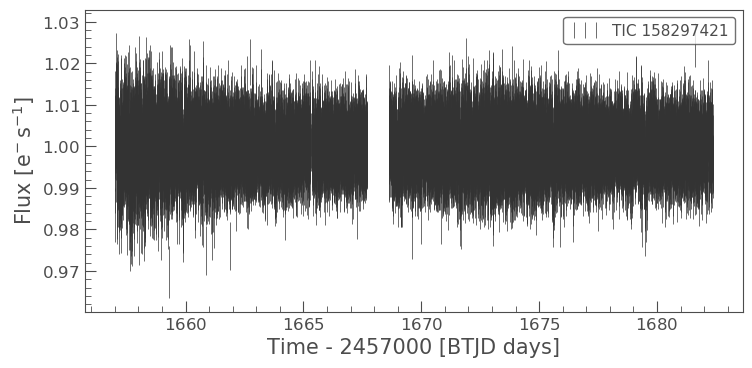

In [158]:
clipped_lc = masked_lc.remove_outliers(sigma=6) #lower the sigma, the more data gets chopped off
#obviously there's such thing as too low a sigma for seeing planets
clipped_lc.errorbar();

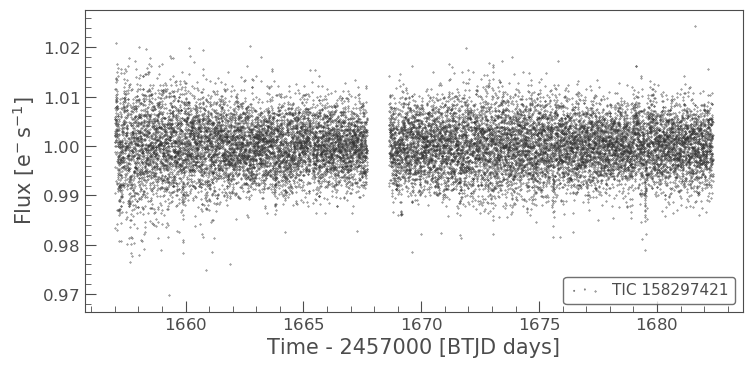

In [159]:
clipped_lc.scatter(s=0.1) #s=marker size
#can add error bars using:
#ax = clipped_lc.scatter(s=.01) 
#clipped_lc.errorbar(ax=ax,alpha=.2) where alpha is transparency

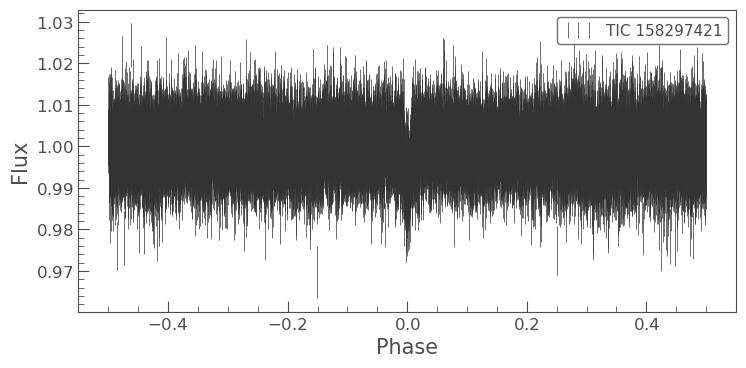

In [160]:
#folding cleaned light curve to see planet transit
folded_lc = masked_lc.fold(period=3.9228038,t0=1659.885) #period=planet period, t0=time of first orbit to fold around
folded_lc.errorbar();
#plt.axvline(x=0.0,color='r')

In [161]:
#now with the light curve properly made and folded, introduce initial fitting

params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.                      #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

t = np.linspace(-0.05, 0.05, 100)

m = batman.TransitModel(params, folded_lc.time)    #initializes model
flux = m.light_curve(params)          #calculates light curve

In [162]:
#adjust fitting by eye
params.per = 3.9228
params.rp = .17
params.inc = 86.2
params.ecc = .0
params.a = 15
m = batman.TransitModel(params, folded_lc.time)
flux = m.light_curve(params)

(-0.03, 0.03)

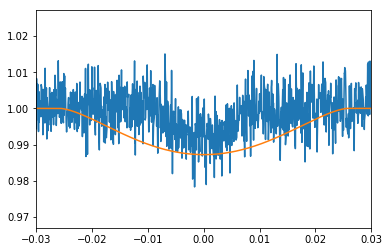

In [168]:
#fit by eye plotted with folded lightcurve
plt.plot(folded_lc.time,folded_lc.flux)
plt.plot(folded_lc.time, flux)
plt.xlim(-.03,.03)

In [169]:
#useful conversions
jupr_convert = 69911 #radius of jupiter to km
sunr_convert = 6.957e8 #radius of sun to km
earthr_convert = 6.371e6 #radius of earth to km
mau_convert = 1/1.496e8 #km to au
aconvert = 149597900000/6.95700e8 #au to r_sun
earthm_convert = 5.972e24 #earth masses to kilograms
sunm_convert = 1.989e30 #sun masses to kilograms

In [170]:
#calculates what a should be from kepler's third law
def a(m1,m2,P):
    G = 6.674e-11
    coeff = G/(4*np.pi*np.pi)
    return (coeff * P * P * (m1+m2))**(1/3)

In [171]:
#the found parameters in the associated paper by Hartman
params_p = batman.TransitParams()
params_p.rp = 0.1746
params_p.inc = 87.08
params_p.ecc = 0
params_p.a = 13.98
params_p.per = 3.9228
params_p.w = 90
params_p.u = [.49, .28]   
params_p.t0 = 0.
params_p.limb_dark = "quadratic" 
m_p = batman.TransitModel(params_p, np.array(folded_lc.time))
flux_p = m_p.light_curve(params_p)

(-0.15, 0.15)

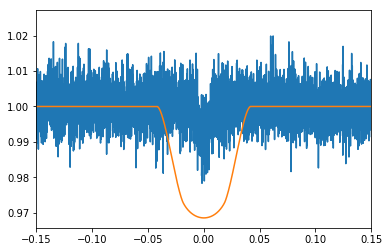

In [172]:
plt.plot(folded_lc.time,folded_lc.flux)
plt.plot(folded_lc.time, flux_p)
plt.xlim(-.15,.15)

radius error(R_sun) = 0.004599999999999993
distance error(AU) = -1.0199999999999996
eccentricity error = 0.0
inclination error(deg) =  0.8799999999999955
period error(days)= 0.0


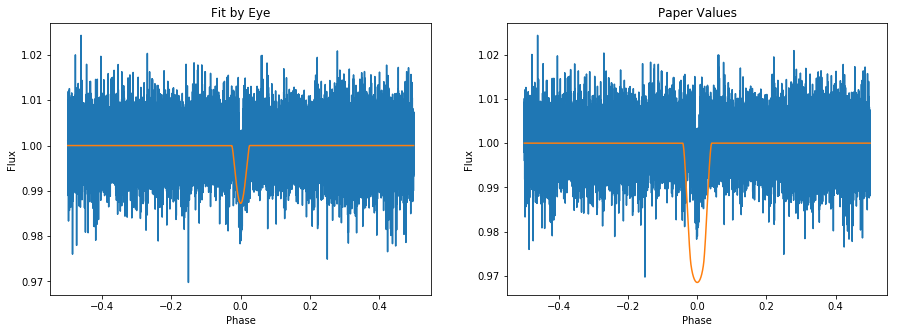

In [173]:
print('radius error(R_sun) =',params_p.rp-params.rp)
print('distance error(AU) =',params_p.a-params.a)
print('eccentricity error =',params_p.ecc-params.ecc)
print('inclination error(deg) = ',params_p.inc-params.inc)
print('period error(days)=', params_p.per-params.per)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(folded_lc.time,folded_lc.flux)
plt.plot(folded_lc.time, flux)
#plt.xlim(-.15,.15)
plt.title('Fit by Eye')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.subplot(1,2,2)
plt.plot(folded_lc.time,folded_lc.flux)
plt.plot(folded_lc.time, flux_p)
#plt.xlim(-.15,.15)
plt.title('Paper Values')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.show()